In [1]:
import os
import torch
import numpy as np
import torch.optim as opt

from tqdm import tqdm
from second.model.second import SECOND
from torch.utils.data import DataLoader
from second.model.losses.total import TotalLoss
from second.utils.model_saver import SaveBestModel
from second.model.scheduler.custom_exponential import CustomExponentialLR
from second.dataset.paris_orleans import PAI_ORLEANS_Dataset, ORLEANS_VOXELS_Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# seed_everything

def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1234)

In [4]:
train_dir = "../../NUAGES_DE_POINTS/PAI_ORLEANS/train/voxels"
valid_dir = "../../NUAGES_DE_POINTS/PAI_ORLEANS/valid/voxels"

train_annot_dir = "../../NUAGES_DE_POINTS/ANNOTATIONS/train/numpy_arrays"
valid_annot_dir = "../../NUAGES_DE_POINTS/ANNOTATIONS/valid/numpy_arrays"

max_voxels = 20000

data_train = ORLEANS_VOXELS_Dataset(
    data_dir=train_dir,
    annotation_dir=train_annot_dir,
    max_voxels=max_voxels
)
data_valid = ORLEANS_VOXELS_Dataset(
    data_dir=valid_dir,
    annotation_dir=valid_annot_dir,
    max_voxels=max_voxels
)

loading data...: 100%|██████████| 38/38 [00:00<00:00, 85.95it/s]


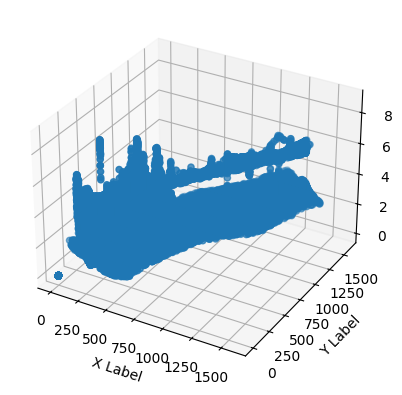

In [7]:
import matplotlib.pyplot as plt

test = data_valid[18][0].numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = test[:,:,0]
ys = test[:,:,1]
zs = test[:,:,2]
ax.scatter(xs, ys, zs)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [3]:
train_dir = "../../NUAGES_DE_POINTS/PAI_ORLEANS/train/clouds"
valid_dir = "../../NUAGES_DE_POINTS/PAI_ORLEANS/valid/clouds"

train_annot_dir = "../../NUAGES_DE_POINTS/ANNOTATIONS/train/boxes"
valid_annot_dir = "../../NUAGES_DE_POINTS/ANNOTATIONS/valid/boxes"

loaded_arrays_dir_train = "../../NUAGES_DE_POINTS/PAI_ORLEANS/train/numpy_arrays"
loaded_arrays_dir_valid = "../../NUAGES_DE_POINTS/PAI_ORLEANS/valid/numpy_arrays"

loaded_annot_arrays_dir_train = "../../NUAGES_DE_POINTS/ANNOTATIONS/train/numpy_arrays"
loaded_annot_arrays_dir_valid = "../../NUAGES_DE_POINTS/ANNOTATIONS/valid/numpy_arrays"

max_number_of_points = 1_500_000
max_number_of_objects = 40
load_raw_clouds = True

data_train = PAI_ORLEANS_Dataset(
    data_dir=train_dir,
    annotation_dir=train_annot_dir,
    loaded_arrays_dir=loaded_arrays_dir_train,
    loaded_annot_arrays_dir=loaded_annot_arrays_dir_train,
    max_number_of_points=max_number_of_points,
    max_number_of_objects=max_number_of_objects,
    load_raw_clouds=load_raw_clouds
)
data_valid = PAI_ORLEANS_Dataset(
    data_dir=valid_dir,
    annotation_dir=valid_annot_dir,
    loaded_arrays_dir=loaded_arrays_dir_valid,
    loaded_annot_arrays_dir=loaded_annot_arrays_dir_valid,
    max_number_of_points=max_number_of_points,
    max_number_of_objects=max_number_of_objects,
    load_raw_clouds=load_raw_clouds
)

saving data into npy format...:   0%|          | 0/160 [00:00<?, ?it/s]

saving data into npy format...: 100%|██████████| 96/96 [24:00<00:00, 15.01s/it] 


In [ ]:
data_train[0][0][:,2]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.2404e+02, 4.4876e+02, 6.3987e+01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        ...,
        [1.7807e+02, 7.3229e+02, 6.5995e+01, 0.0000e+00],
        [1.9139e+02, 4.9197e+02, 5.9121e+01, 3.1727e+04],
        [3.1082e+01, 6.7588e+01, 5.9693e+01, 3.6408e+04]])

In [ ]:
# Hyperparameters definition

batch_size = 1
num_epochs = 160
learning_rate = 2e-4
weight_decay = 1e-4
exp_decay = 0.8
decay_step = 15

num_classes = 4
num_regression_offsets = 7
num_directions = 2
in_features = 4

train_loader = DataLoader(
    dataset=data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)
valid_loader = DataLoader(
    dataset=data_valid,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

In [ ]:
def initialize_weights(module):
    if isinstance(module, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight.data)
        module.bias.data.zero_()

In [ ]:
# Training function

def train_epoch(epoch, num_epochs, model, optimizer, scheduler, dataloader, criterion):
    model.train()
    model.apply(initialize_weights)
    total_loss = 0
    foc = 0
    reg = 0
    drc = 0
    progress = tqdm(dataloader, total=len(dataloader))

    for voxels, coors, class_pos, targets, directions in progress:
        voxels = voxels.to(device)
        coors = coors.to(device)
        class_pos = class_pos.to(device)
        targets = targets.to(device)
        directions = directions.to(device)

        # Zero the gradients for every batch !
        optimizer.zero_grad()

        # Make predictions for this batch
        score, regression, direction = model(voxels, coors)

        # Compute the loss and its gradients
        train_loss, focal_loss, reg_loss, dir_loss = criterion(
            score, regression, direction, class_pos, targets, directions
        )
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        total_loss += train_loss.item()
        foc += focal_loss.item()
        reg += reg_loss.item()
        drc += dir_loss.item()
        progress.set_description(
            f"[{epoch + 1:.2g}/{num_epochs:.2g}] train loss: {total_loss:.2f} || "
            f"Focal Loss: {foc:.2f} || Reg Loss: {reg:.2f} || "
            f"Dir Loss: {drc:.2f}"
        )

    # Update the scheduler
    scheduler.step()

    return total_loss

In [ ]:
# Validation function

def validate_epoch(model, dataloader, criterion):
    total_loss = 0
    foc = 0
    reg = 0
    drc = 0
    model.eval()

    with torch.no_grad():
        progress = tqdm(dataloader, total=len(dataloader))

        for voxels, coors, class_pos, targets, directions in progress:
            voxels = voxels.to(device)
            coors = coors.to(device)
            class_pos = class_pos.to(device)
            targets = targets.to(device)
            directions = directions.to(device)

            score, regression, direction = model(voxels, coors)
            valid_loss, focal_loss, reg_loss, dir_loss = criterion(
                score, regression, direction, class_pos, targets, directions
            )

            total_loss += valid_loss.item()
            foc += focal_loss.item()
            reg += reg_loss.item()
            drc += dir_loss.item()
            progress.set_description(
                f"[VALID] valid loss: {total_loss:.2f} || "
                f"Focal Loss: {foc:.2f} || Reg Loss: {reg:.2f} || "
                f"Dir Loss: {drc:.2f}"
            )

    return total_loss, foc, reg, drc

In [ ]:
# Training Loop

best_loss_val = float("inf")
saver = SaveBestModel(best_valid_loss=best_loss_val)
valid, focal, reg, drc = [], [], [], []

model = SECOND(
                in_features=in_features,
                num_classes=num_classes,
                num_regression_offsets=num_regression_offsets,
                num_directions=num_directions,
            )
model.to(device)

criterion = TotalLoss(device=device)
criterion.to(device)

adam = opt.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

exponential = CustomExponentialLR(
    optimizer=adam,
    decay_factor=exp_decay,
    decay_step=decay_step,
    initial_lr=learning_rate,
)

for epoch in range(num_epochs):
    train_loss = train_epoch(
        epoch,
        num_epochs=num_epochs,
        model=model,
        optimizer=adam,
        scheduler=exponential,
        dataloader=train_loader,
        criterion=criterion
    )
    valid_loss, focal_loss, reg_loss, dir_loss = validate_epoch(
        model=model,
        dataloader=valid_loader,
        criterion=criterion
    )

    if valid_loss < best_loss_val:
        best_loss_val = valid_loss
        saver.save(
            current_valid_loss=best_loss_val,
            epoch=epoch,
            model=model,
            optimizer=adam,
            scheduler=exponential,
            criterion=criterion
        )
        ## save the checkpoints

    valid.append(valid_loss)
    focal.append(focal_loss)
    reg.append(reg_loss)
    drc.append(dir_loss)

[1/1.6e+02] train loss: 611.44 || Focal Loss: 575.70 || Reg Loss: 8.03 || Dir Loss: 73.95: 100%|██████████| 110/110 [01:07<00:00,  1.63it/s]
[VALID] valid loss: 200.48 || Focal Loss: 195.07 || Reg Loss: 0.25 || Dir Loss: 19.75: 100%|██████████| 38/38 [00:19<00:00,  1.94it/s]



Best validation loss: 200.4770965576172

Saving best model for epoch: 1



[2/1.6e+02] train loss: 595.35 || Focal Loss: 567.06 || Reg Loss: 5.93 || Dir Loss: 64.91: 100%|██████████| 110/110 [01:05<00:00,  1.68it/s]
[VALID] valid loss: 198.42 || Focal Loss: 195.38 || Reg Loss: 0.07 || Dir Loss: 13.38: 100%|██████████| 38/38 [00:19<00:00,  1.94it/s]



Best validation loss: 198.4171953201294

Saving best model for epoch: 2



[3/1.6e+02] train loss: 592.70 || Focal Loss: 566.76 || Reg Loss: 5.93 || Dir Loss: 53.50: 100%|██████████| 110/110 [01:05<00:00,  1.68it/s]
[VALID] valid loss: 196.02 || Focal Loss: 194.19 || Reg Loss: 0.04 || Dir Loss: 8.45: 100%|██████████| 38/38 [00:19<00:00,  1.94it/s]



Best validation loss: 196.0243525505066

Saving best model for epoch: 3



[4/1.6e+02] train loss: 589.96 || Focal Loss: 565.94 || Reg Loss: 5.33 || Dir Loss: 51.73: 100%|██████████| 110/110 [01:10<00:00,  1.55it/s]
[VALID] valid loss: 195.72 || Focal Loss: 194.10 || Reg Loss: 0.04 || Dir Loss: 7.44: 100%|██████████| 38/38 [00:19<00:00,  1.94it/s]



Best validation loss: 195.72479343414307

Saving best model for epoch: 4



[5/1.6e+02] train loss: 96.05 || Focal Loss: 84.32 || Reg Loss: 3.75 || Dir Loss: 12.62:  15%|█▍        | 16/110 [00:09<00:55,  1.69it/s]